In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma

In [3]:
def convertDate(d):
    date = datetime.datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p')
    return datetime.date(date.year, date.month, date.day)

In [4]:
complaints = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', converters={'Created Date': convertDate})

In [5]:
complaints = complaints.rename(columns = {'Created Date': 'Date'})
complaints['dow'] = complaints.apply(lambda x: x['Date'].weekday(), axis=1)
complaints['month'] = complaints.apply(lambda x: x['Date'].month, axis=1)

In [6]:
def convertStreak(streak):
    # N is post season?
    #if streak == "N":
    #    return float('Nan')
    if not streak:
        return float('Nan')
    sign = -1 if streak[0] == "-" else 1
    return len(streak) * sign

def getDateConverter(year):
    def convertDate(date):
        # Handle duplicate headers
        if date == 'Date':
            return None
        
        # Remove double-header indication (1), (2) and convert to date
        d = datetime.datetime.strptime(re.sub(r'\s\(.*\)', '', date) + ' ' + str(year), '%A %b %d %Y')
        #d.year = year
        return datetime.date(d.year, d.month, d.day)
    
    return convertDate

def convertWL(wl):
    # Covert the W/L column to numeric
    if wl and wl[0] == 'W':
        return 1
    return 0

def readGameLog(csv, convertDate):
    df = pd.read_csv(csv, skip_blank_lines=True, converters={'Streak': convertStreak, 'Date': convertDate, 'W/L': convertWL})
    
    # Remove the headers in the middle of the file and postseason
    df = df.drop(df.index[
        (df.Rk == "Rk") # Drop header rows
    ])
    
    #print [d.days for d in np.diff(df.Date)]
    
    # First game in double headers
    df = df.drop(df.index[(np.append([d.days for d in np.diff(df.Date)], [1]) == 0)])
    
    return df

In [7]:
dfs = []
years = range(2010,2016)
for year in years:
    dfs.append(readGameLog("teams_NYY_%s-schedule-scores_team_schedule.csv" % str(year), getDateConverter(year)))
    
baseball = pd.concat(dfs, ignore_index=True)

In [8]:
#Flag for postseason games
baseball['postseason'] = np.isnan(baseball.Rk.astype('float'))

In [9]:
merged = pd.merge(baseball, complaints, on='Date')

In [10]:
def doStuff(df):
    grouped = df.groupby('Date')
    
    # Get numbers for each day
    streak = []
    counts = []
    dow = []
    post = []
    month = []
    for d in sorted(grouped.groups.keys()):
        mean = grouped.get_group(d).mean()
        streak.append(mean['Streak'])
        dow.append(mean['dow'])
        counts.append(grouped.get_group(d).count()['Date'])
        post.append(mean['postseason'])
        month.append(mean['month'])
        
    # Detrend number of complaints
    cycle, trend = sma.tsa.filters.hpfilter(counts, lamb = 104976000000)
    
    # Plot Complaints vs. Streak
    figure, ax = pl.subplots(figsize=(16,16))
    ax.scatter(streak, cycle)

    mod = smf.ols(formula='c ~ s', data = {'c': cycle, 's': streak}).fit()
    print mod.summary()
    abline_plot(model_results=mod, ax=ax, color='red')
    ax.set_title('311 Complaints (Cycle) vs Win Streak (NYY)')
    ax.set_xlabel('Win Streak')
    ax.set_ylabel('311 Complaint Cycle')
    
    # Run Regression vs. Everything
    mod = smf.ols(formula='c ~ s + C(d) + p + C(m)', data = {'c': cycle, 's': streak, 'd': dow, 'p': post, 'm': month}).fit()
    print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2239
Date:                Mon, 09 Nov 2015   Prob (F-statistic):              0.636
Time:                        00:28:27   Log-Likelihood:                -8426.2
No. Observations:                 979   AIC:                         1.686e+04
Df Residuals:                     977   BIC:                         1.687e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.5632     43.005      0.083      0.9

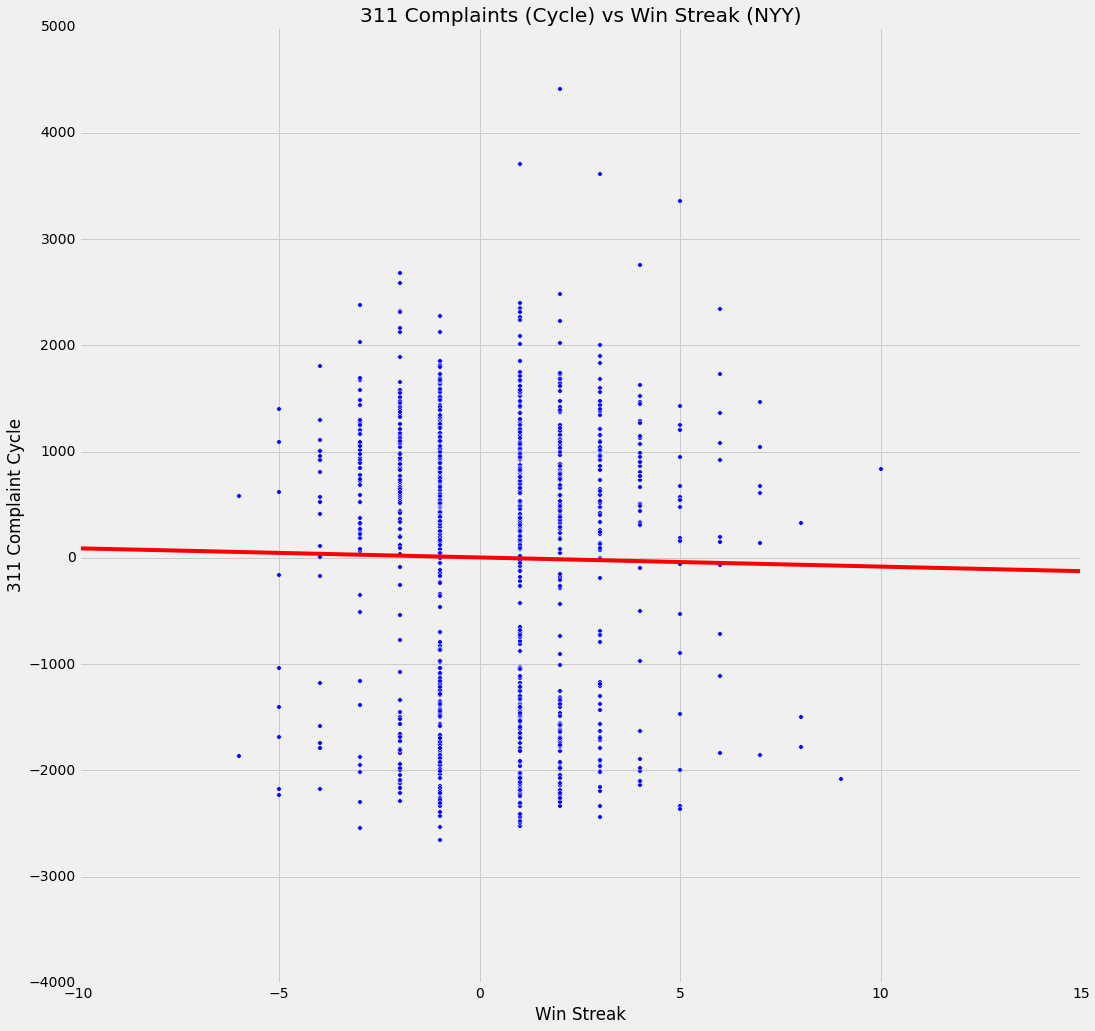

In [11]:
doStuff(merged)

In [12]:
noise = merged[merged['Complaint Type'].str.contains('Noise')]

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6664
Date:                Mon, 09 Nov 2015   Prob (F-statistic):              0.415
Time:                        00:28:34   Log-Likelihood:                -6258.5
No. Observations:                 979   AIC:                         1.252e+04
Df Residuals:                     977   BIC:                         1.253e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.6723      4.698     -0.143      0.8

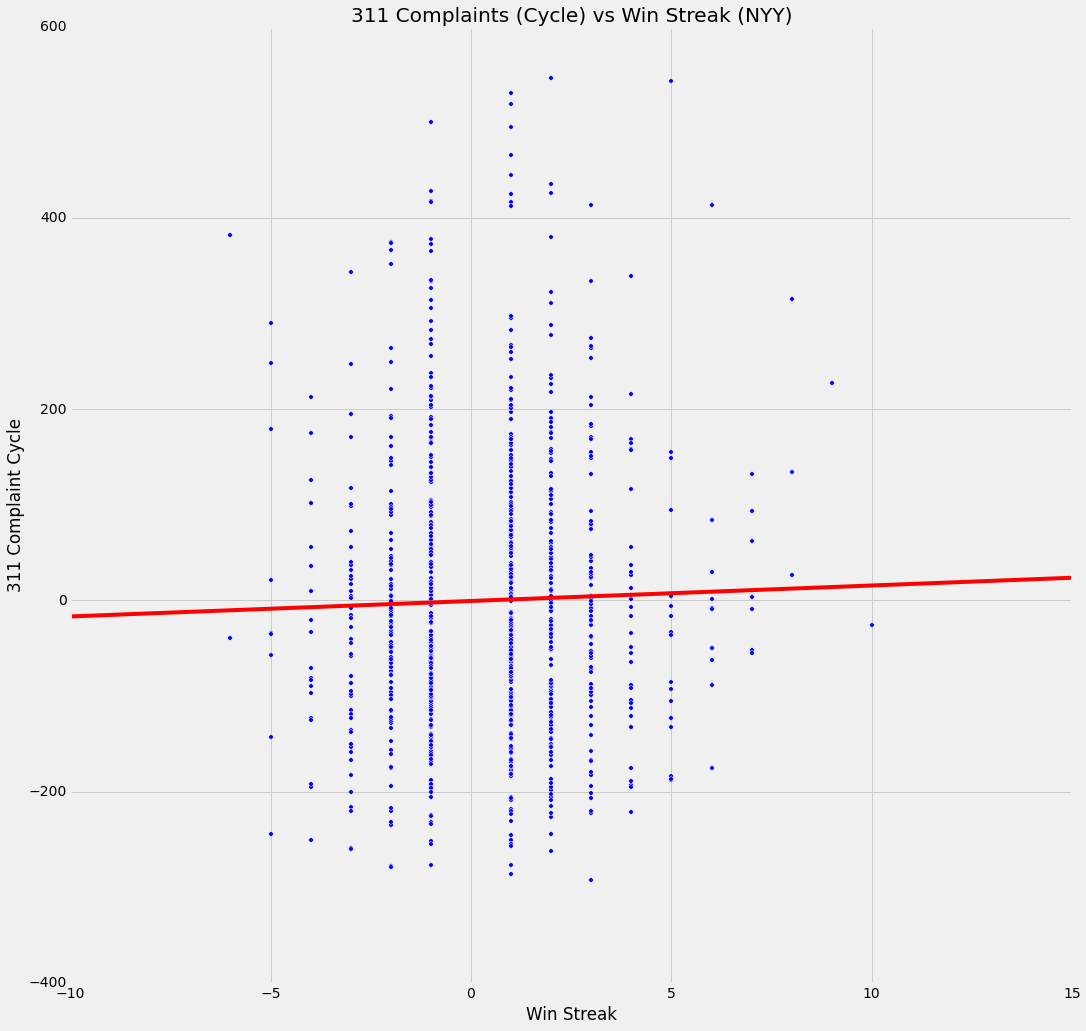

In [13]:
doStuff(noise)

In [14]:
wonoise = merged[~merged['Complaint Type'].str.contains('Noise')]

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2834
Date:                Mon, 09 Nov 2015   Prob (F-statistic):              0.595
Time:                        00:29:21   Log-Likelihood:                -8480.0
No. Observations:                 979   AIC:                         1.696e+04
Df Residuals:                     977   BIC:                         1.697e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.2355     45.435      0.093      0.9

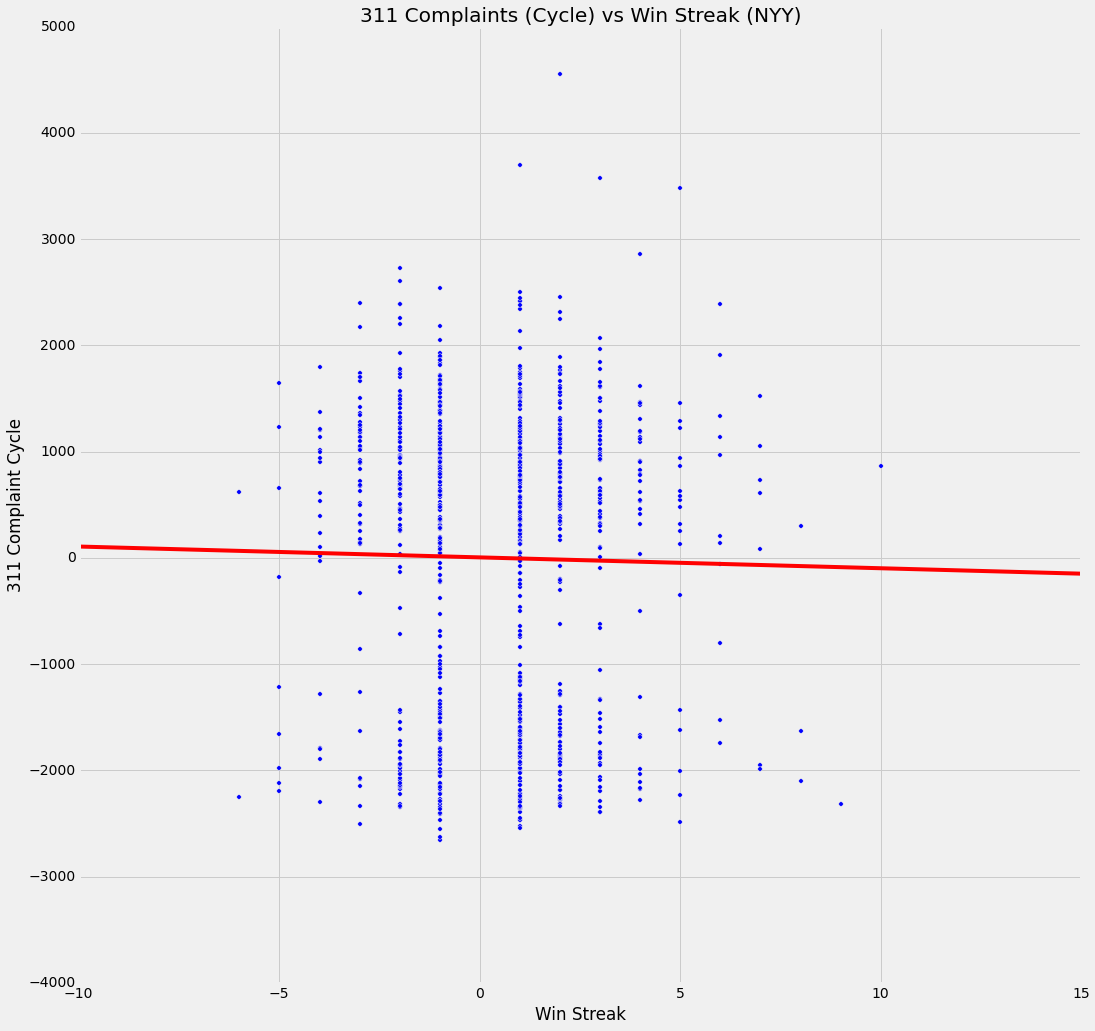

In [15]:
doStuff(wonoise)